<a href="https://colab.research.google.com/github/FranciellyCastro/2D-Truss-FEM/blob/main/2D_Truss_FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Códigos curso Análise Estrutura por MEF

Deslocamentos nodais no sistema global em mm
d 1 = 0.000000 (mm)
d 2 = 0.000000 (mm)
d 3 = 0.307387 (mm)
d 4 = 0.063662 (mm)
d 5 = 0.063662 (mm)
d 6 = 0.000000 (mm)

Deformação 1  = 3.183e-5
Tensão 1  = 6.366e+6 Pa
Deformação 2  = -4.502e-5
Tensão 2  = -9.003e+6 Pa
Deformação 3  = 3.183e-5
Tensão 3  = 6.366e+6 Pa

Reação 1 = -500.00 (N)
Reação 2 = -500.00 (N)
Reação 3 = 500.00 (N)


Text(0.5, 0, 'Comprimento (m)')

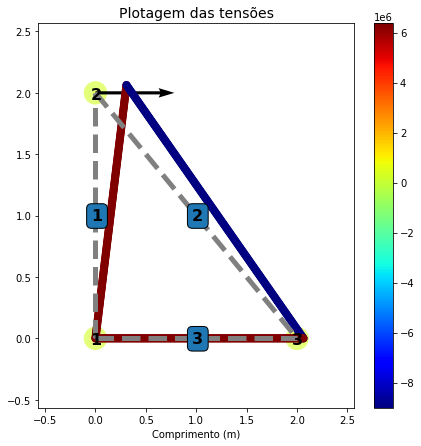

In [ ]:
# Aula 11 - Extensão
# Pré-Processamento
import numpy as np
import copy
# 1) Parâmetros a serem definidos para o a análise via FEM
conec = np.array([[1,2],[2,3],[1,3]]) # Matriz conectividade
coord = np.array([[0,0],[0,2],[2,0]]) # Matriz coordenadas nodais
# -----------------------------------------------------------------------------
nel = len(conec) # Número de elementos totais
nno = len(coord) # Número de nós
# -----------------------------------------------------------------------------
E = 200E9*np.ones(nel) # Módulo de elasticidade elementar
D = 0.01*np.ones(nel)
# -----------------------------------------------------------------------------
# 2a) Defina os graus de liberdade que contenham as condições de contorno de deslocamento
# lembrando que os graus de liberdade no python começam em 0
CCDir_gdl = [0,1,5] 
# 3b) Defina os graus de liberdade que contenham as condições de contorno de força e seu respectivo valor
# lembrando que os graus de liberdade no python começam em 0
F_gdl = np.array([[2,500]])
# -----------------------------------------------------------------------------
# Processamento
# Superposição da matriz Kg
Kg = np.zeros((2*nno,2*nno)) # Abrindo espaço para matriz de rigidez global (NGdl,NGdl)
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    Lx = coord[no2-1,0]-coord[no1-1,0]
    Ly = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(Lx**2+Ly**2) # Vetor comprimento dos elementos
    Cos = Lx/L
    Sen = Ly/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matriz de transformação de coordenadas
    A = np.pi*(D[el]/2)**2 # Área elementar
    k = (E[el]*A/L)*np.array([[1,-1],[-1,1]])
    ke = np.transpose(T).dot(k).dot(T)
    # Superposição da matriz elementar na matriz de rigidez global --------
    # Posições dos GLs nodais no sistema global
    GLel = np.array([[2*no1 - 2],[2*no1 - 1],[2*no2 - 2],[2*no2 - 1]])
    for i in range(0,len(GLel)):
        for j in range(0,len(GLel)):
            Kg[GLel[i],GLel[j]] = Kg[GLel[i],GLel[j]] + ke[i,j]         
Kg1 = copy.deepcopy(Kg)
# Aplicação das condições de contorno
# Condições de contorno de força
F = np.zeros((2*nno))
for igl in range(len(F_gdl)):
  F[F_gdl[igl,0]] = F_gdl[igl,1]
# Condições de contorno de deslocamento 
CCDir = np.zeros((2*nno,2))
for i in range(len(CCDir_gdl)):
  CCDir[CCDir_gdl[i],0] = 1   
for igl in range(2*nno):
  if CCDir[igl-1,0] == 1:
    up = CCDir[igl-1,1]  
    for i in range(2*nno): # zera linha e coluna
      Kg[i-1,igl-1] = 0.0
      Kg[igl-1,i-1] = 0.0   
    Kg[igl-1,igl-1] = 1; # Prescreve 1 no G.L.  
# Solução do sistema linear de equações
d = np.linalg.solve(Kg,F)
print('Deslocamentos nodais no sistema global em mm')
for igl in range(2*nno):
    print('d',igl+1, '= %.6f (mm)' % (1000*d[igl]))
print('')
# Pós-processamento
e = np.zeros((nel,1))
Tens = np.zeros((nel,1))
for el in range(0,nel):
    # Cálculo do deslocamento elementar
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Vetor comprimento dos elementos
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matriz de transformação de coordenadas
    d_el = np.array([d[2*no1 - 2],d[2*no1-1],d[2*no2 - 2],d[2*no2-1]])
    u = T.dot(d_el)
    # Cálculo da deformação e tensão elementar
    e[el] = (u[1] - u[0])/L
    Tens[el] = E[el]*e[el]
    print('Deformação', el+1, ' =',np.format_float_scientific(e[el], precision = 3, exp_digits=1))
    print('Tensão', el+1, ' =', np.format_float_scientific(float(Tens[el]), precision = 3, exp_digits=1),'Pa')
print('')
# Cálculo das reações de apoio
for igl in range(len(CCDir_gdl)):
    R = np.inner(Kg1[CCDir_gdl[igl],:], d.T)
    print('Reação',igl + 1, '= %.2f (N)' %R)
# Plotagem dos resultados
import matplotlib.pyplot as plt
SizeSpace = (max(coord[:,0])**2 + max(coord[:,1])**2)**0.5
SF = 10 # Fator de tamanho
fig, axs = plt.subplots(1,1,figsize=((max(coord[:,0])/SizeSpace)*SF,(max(coord[:,1])/SizeSpace)*SF))
axs.set(xlim=(-0.2*SizeSpace, max(coord[:,0])+0.2*SizeSpace), ylim=(-0.2*SizeSpace, max(coord[:,1])+0.2*SizeSpace)) 
# Plotagem da estrutura inicial
disc = 200 # discretização
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0]
    y1 = coord[no1-1,1]
    x2 = coord[no2-1,0]
    y2 = coord[no2-1,1]
    plt.plot([x1,x2],[y1,y2],color='grey',linestyle='--',linewidth=5)
# Plotagem dos nós
nox = coord[:,0]
noy = coord[:,1]
colors = 100*np.ones(nno)
plt.scatter(nox,noy,c=colors,s=500, cmap='Wistia')
# Número dos nós
for i in range(nno):
    plt.text(nox[i]-max(coord[:,0])*0.025, noy[i]-max(coord[:,1])*0.025, i+1, fontsize=16,fontweight='bold')    
# Número dos elementos
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    plt.text(coord[no1-1,0]+ x/2-max(coord[:,0])*0.02, coord[no1-1,1]+y/2-max(coord[:,1])*0.02, el+1, 
             fontsize=16,fontweight='bold',bbox=dict(boxstyle="round"))  
# Plotagem das forças
for ino in range(0,nno):
  if F[2*ino] != 0:
    xix = coord[ino,0]
    yix = coord[ino,1]
    xfx = F[2*ino]/abs(F[2*ino])
    yfx = 0
    plt.quiver(xix,yix,xfx,yfx,scale = 2*max(coord[:,0]),width=0.01)
  if F[2*ino+1] != 0:
    xiy = coord[ino,0]
    yiy = coord[ino,1]
    xfy = 0
    yfy = F[2*ino+1]/abs(F[2*ino+1])
    plt.quiver(xiy,yiy,xfy,yfy,scale = 2*max(coord[:,1]),width=0.01) 
# Plotagem da estrutura deformada   
disc = 200 # discretização
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
colors = np.zeros((nel*disc))
diamplot = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0] + 1000*d[2*no1 - 2] 
    y1 = coord[no1-1,1] + 1000*d[2*no1-1]
    x2 = coord[no2-1,0] + 1000*d[2*no2 - 2]
    y2 = coord[no2-1,1] + 1000*d[2*no2-1]
    x_aux = np.asfarray(np.linspace(x1,x2,disc), dtype='float')
    y_aux = np.asfarray(np.linspace(y1,y2,disc), dtype='float')
    for j in range(0,disc):
        x[disc*(el+1)-disc+j] = x_aux[j]
        y[disc*(el+1)-disc+j] = y_aux[j]
        colors[disc*(el+1)-disc+j] = Tens[el]
        diamplot[disc*(el+1)-disc+j] = 5e3*D[el]  
plt.scatter(x,y,c=colors,s=diamplot, cmap='jet') 
plt.colorbar()     
plt.title("Plotagem das tensões", fontsize=14)
plt.xlabel('Comprimento (m)')

Massa total inicial da treliça é = 4.231 kg

A massa total ótima da treliça é = 1.262 kg

D 1 = 5.0463 (mm)
D 2 = 6.0011 (mm)
D 3 = 5.0463 (mm)

Tens 1 = 250.0000 (MPa)
Tens 2 = -250.0001 (MPa)
Tens 3 = 250.0000 (MPa)


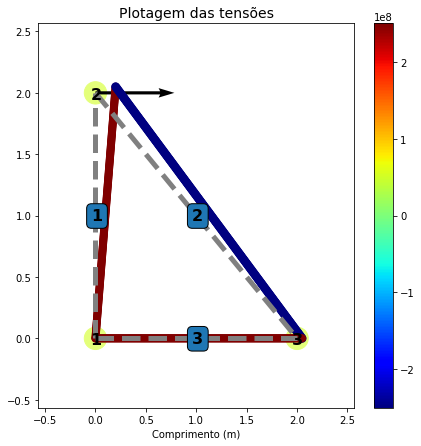

In [ ]:
# Aula 12 - Extensão
# Otimização de treliça plana
import numpy as np
import scipy as sp
from scipy import optimize
import copy
# 1) Parâmetros a serem definidos para o a análise via FEM
conec = np.array([[1,2],[2,3],[1,3]]) # Matriz conectividade
coord = np.array([[0,0],[0,2],[2,0]]) # Matriz coordenadas nodais
# -----------------------------------------------------------------------------
nel = len(conec) # Número de elementos totais
nno = len(coord) # Número de nós
# -----------------------------------------------------------------------------
E = 200E9*np.ones(nel) # Módulo de elasticidade elementar
# -----------------------------------------------------------------------------
# 2) Parâmetros a serem definidos para o processo de otimização
# Defina a densidade do material para o cálculo da massa da estrutura
dens = 7890 # Densidade do material em kg/m³
# Defina a tensão de escoamento do material para o cálculo das restrições
Tesc = 250E6 # Tensão de escomanto do Aço A36 em MPa
# Defina o diâmetro inicial das barras da estrutura
D0 = 0.01*np.ones(nel)
# Defina os limites inferior e superior para para cada variável (diâmetro)
b = (0.002,0.05)
# -----------------------------------------------------------------------------
limites = np.zeros((nel,2))
for el in range(0,nel):
  limites[el,:] = b
# -----------------------------------------------------------------------------
# 3a) Defina os graus de liberdade que contenham as condições de contorno de deslocamento
# lembrando que os graus de liberdade no python começam em 0
CCDir_gdl = [0,1,5] 
# 3b) Defina os graus de liberdade que contenham as condições de contorno de força e seu respectivo valor
# lembrando que os graus de liberdade no python começam em 0
F_gdl = np.array([[2,5000]])
# -----------------------------------------------------------------------------
# Cálculo da massa inicial do sistema considerando o D0 definido
massai = 0 
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Vetor comprimento dos elementos
    A = np.pi*(D0[el]/2)**2 # Área elementar
    massai = massai + dens*A*L
print('Massa total inicial da treliça é = %.3f' % massai, 'kg')
# Plotagem da estrutura inicial
import matplotlib.pyplot as plt
SizeSpace = (max(coord[:,0])**2 + max(coord[:,1])**2)**0.5
SF = 10 # Fator de tamanho
fig, axs = plt.subplots(1,1,figsize=((max(coord[:,0])/SizeSpace)*SF,(max(coord[:,1])/SizeSpace)*SF))
axs.set(xlim=(-0.2*SizeSpace, max(coord[:,0])+0.2*SizeSpace), ylim=(-0.2*SizeSpace, max(coord[:,1])+0.2*SizeSpace)) 
# Plotagem da estrutura inicial
disc = 200 # discretização
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0]
    y1 = coord[no1-1,1]
    x2 = coord[no2-1,0]
    y2 = coord[no2-1,1]
    plt.plot([x1,x2],[y1,y2],color='grey',linestyle='--',linewidth=5)
# Plotagem dos nós
nox = coord[:,0]
noy = coord[:,1]
colors = 100*np.ones(nno)
plt.scatter(nox,noy,c=colors,s=500, cmap='Wistia')
# Número dos nós
for i in range(nno):
    plt.text(nox[i]-max(coord[:,0])*0.025, noy[i]-max(coord[:,1])*0.025, i+1, fontsize=16,fontweight='bold')    
# Número dos elementos
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    plt.text(coord[no1-1,0]+ x/2-max(coord[:,0])*0.02, coord[no1-1,1]+y/2-max(coord[:,1])*0.02, el+1, 
             fontsize=16,fontweight='bold',bbox=dict(boxstyle="round"))       
plt.title("Plotagem das tensões", fontsize=14)
plt.xlabel('Comprimento (m)')  
# Algoritmo para Otimização de Treliças 2D
# Cálculo da função objetivo (massa total da treliça)
def funobj(D):
  massa = 0
  for el in range(0,nel):
      no1 = conec[el,0]
      no2 = conec[el,1]
      x = coord[no2-1,0]-coord[no1-1,0]
      y = coord[no2-1,1]-coord[no1-1,1]
      L = np.sqrt(x**2+y**2) # Vetor comprimento dos elementos
      A = np.pi*(D[el]/2)**2 # Área elementar
      massa = massa + dens*A*L
  return massa
# Cálculo das tensões para análise das restrições  
def Tensao(D):
  Kg = np.zeros((2*nno,2*nno)) # Abrindo espaço para matriz de rigidez global (NGdl,NGdl)
  for el in range(0,nel):
      no1 = conec[el,0]
      no2 = conec[el,1]
      x = coord[no2-1,0]-coord[no1-1,0]
      y = coord[no2-1,1]-coord[no1-1,1]
      L = np.sqrt(x**2+y**2) # Vetor comprimento dos elementos
      Cos = x/L
      Sen = y/L
      T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matriz de transformação de coordenadas
      A = np.pi*(D[el]/2)**2 # Área elementar
      k = (E[el]*A/L)*np.array([[1,-1],[-1,1]])
      ke = np.transpose(T).dot(k).dot(T)
      # Superposição da matriz elementar na matriz de rigidez global --------
      # Posições dos GLs nodais no sistema global
      GLel = np.array([[2*no1 - 2],[2*no1 - 1],[2*no2 - 2],[2*no2 - 1]])
      for i in range(0,len(GLel)):
          for j in range(0,len(GLel)):
              Kg[GLel[i],GLel[j]] = Kg[GLel[i],GLel[j]] + ke[i,j]         
  # Aplicação das condições de contorno
  # Condições de contorno de força
  F = np.zeros((2*nno))
  for igl in range(len(F_gdl)):
    F[F_gdl[igl,0]] = F_gdl[igl,1]
  # Condições de contorno de deslocamento 
  CCDir = np.zeros((2*nno,2))
  for i in range(len(CCDir_gdl)):
      CCDir[CCDir_gdl[i],0] = 1   
  for igl in range(2*nno):
      if CCDir[igl-1,0] == 1:
        up = CCDir[igl-1,1]  
        for i in range(2*nno): # zera linha e coluna
            Kg[i-1,igl-1] = 0.0
            Kg[igl-1,i-1] = 0.0   
        Kg[igl-1,igl-1] = 1; # Prescreve 1 no G.L.  
  # Solução do sistema linear de equações
  d = np.linalg.solve(Kg,F)
  # Pós-processamento
  e = np.zeros((nel,1))
  Tens = np.zeros((nel,1))
  # Cálculo do deslocamento elementar
  for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Vetor comprimento dos elementos
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matriz de transformação de coordenadas
    d_el = np.array([d[2*no1 - 2],d[2*no1-1],d[2*no2 - 2],d[2*no2-1]])
    u = T.dot(d_el)
    # Cálculo da deformação e tensão elementar
    e[el] = (u[1] - u[0])/L
    Tens[el] = E[el]*e[el]
  return Tens, d, F
# Cálculo das restrições
def restricoes(D):
  Tens, d, F = Tensao(D)
  restricao = np.zeros((nel))
  StrNormTra = 1/Tesc
  StrNormCom = 1/Tesc
  for el in range(0,nel):
    if Tens[el] >= 0:
      restricao[el] = StrNormTra*(Tesc - float(Tens[el]))
    else:
      restricao[el] = StrNormCom*(float(Tens[el]) + Tesc)
  return restricao 
cons = ({'type': 'ineq', 'fun': restricoes}) # Restrições = constraints
# Solução do problema de otimização utilizando a função minimize 
sol = sp.optimize.minimize(funobj,D0,method='SLSQP',bounds=limites,constraints=cons,tol = 1E-6)
#print(sol)
print('')
print('A massa total ótima da treliça é = %.3f' % sol.fun, 'kg')
print('')
for el in range(0,nel):
  print('D',el + 1, '= %.4f (mm)' %(1000*sol.x[el]))
Tens, d, F = Tensao(sol.x)  
print('')
for el in range(0,nel):  
  print('Tens',el + 1, '= %.4f (MPa)' %(Tens[el]/1E6))
# Plotagem das forças
for ino in range(0,nno):
  if F[2*ino] != 0:
    xix = coord[ino,0]
    yix = coord[ino,1]
    xfx = F[2*ino]/abs(F[2*ino])
    yfx = 0
    plt.quiver(xix,yix,xfx,yfx,scale = 2*max(coord[:,0]),width=0.01)
  if F[2*ino+1] != 0:
    xiy = coord[ino,0]
    yiy = coord[ino,1]
    xfy = 0
    yfy = F[2*ino+1]/abs(F[2*ino+1])
    plt.quiver(xiy,yiy,xfy,yfy,scale = 2*max(coord[:,1]),width=0.01)   
# Plotagem da estrutura final com D ótimo
disc = 200 # discretização
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
colors = np.zeros((nel*disc))
diamplot = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0] + 20*d[2*no1 - 2] 
    y1 = coord[no1-1,1] + 20*d[2*no1-1]
    x2 = coord[no2-1,0] + 20*d[2*no2 - 2]
    y2 = coord[no2-1,1] + 20*d[2*no2-1]
    x_aux = np.asfarray(np.linspace(x1,x2,disc), dtype='float')
    y_aux = np.asfarray(np.linspace(y1,y2,disc), dtype='float')
    for j in range(0,disc):
        x[disc*(el+1)-disc+j] = x_aux[j]
        y[disc*(el+1)-disc+j] = y_aux[j]
        colors[disc*(el+1)-disc+j] = Tens[el]
        diamplot[disc*(el+1)-disc+j] = 1e4*sol.x[el]  
plt.scatter(x,y,c=colors,s=diamplot, cmap='jet') 
plt.colorbar()

Tensão 1  = 6.621e+6 Pa
Tensão 2  = 6.621e+6 Pa
Tensão 3  = 9.677e+6 Pa
Tensão 4  = 9.677e+6 Pa
Tensão 5  = 0.e+0 Pa
Tensão 6  = 3.121e+6 Pa
Tensão 7  = 8.828e+6 Pa
Tensão 8  = -1.200e+6 Pa
Tensão 9  = 6.112e+6 Pa
Tensão 10  = -9.363e+6 Pa
Tensão 11  = -9.87e+6 Pa
Tensão 12  = -9.87e+6 Pa
Tensão 13  = -1.368e+7 Pa



Text(0, 0.5, 'Comprimento (m)')

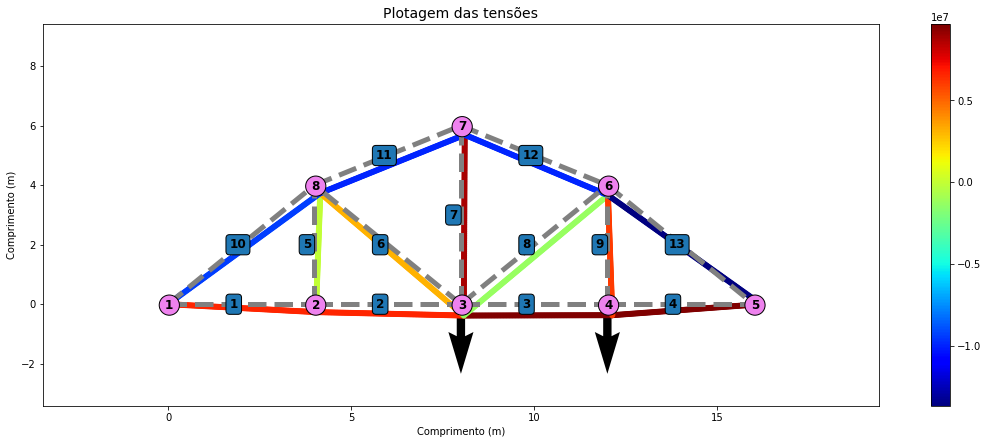

In [ ]:
# Para a treliça apresentada abaixo, determine a tensão no elemento GF. Considere que o material 
# das barras é alumínio 6061-T6 com E=68,9 GPa e o diâmetro das barras é 25 mm. 
# Você pode adaptar o código desenvolvido na aula 11 ao problema.
# Pré-Processamento
import numpy as np
import copy
# 1) Parâmetros a serem definidos para o a análise via FEM
conec = np.array([[1,2],[2,3],[3,4],[4,5],[2,8],[3,8],[3,7],[3,6],[4,6],[1,8],[8,7],[7,6],[6,5]]) # Matriz conectividade
coord = np.array([[0,0],[4,0],[8,0],[12,0],[16,0],[12,4],[8,6],[4,4]]) # Matriz coordenadas nodais
# -----------------------------------------------------------------------------
nel = len(conec) # Número de elementos totais
nno = len(coord) # Número de nós
# -----------------------------------------------------------------------------
E = 68.9E9*np.ones(nel) # Módulo de elasticidade elementar
D = 0.025*np.ones(nel) # Diâmetro de cada elemento
# -----------------------------------------------------------------------------
# 2a) Defina os graus de liberdade que contenham as condições de contorno de deslocamento
# lembrando que os graus de liberdade no python começam em 0
CCDir_gdl = [0,1,9]
# 3b) Defina os graus de liberdade que contenham as condições de contorno de força e seu respectivo valor
# lembrando que os graus de liberdade no python começam em 0
F_gdl = np.array([[5,-5000],[7,-3000]])
# -----------------------------------------------------------------------------
# Processamento
# Superposição da matriz Kg
Kg = np.zeros((2*nno,2*nno)) # Abrindo espaço para matriz de rigidez global (NGdl,NGdl)
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Vetor comprimento dos elementos
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matriz de transformação de coordenadas
    A = np.pi*(D[el]/2)**2 # Área elementar
    k = (E[el]*A/L)*np.array([[1,-1],[-1,1]])
    ke = np.transpose(T).dot(k).dot(T)
    # Superposição da matriz elementar na matriz de rigidez global --------
    # Posições dos GLs nodais no sistema global
    GLel = np.array([[2*no1 - 2],[2*no1 - 1],[2*no2 - 2],[2*no2 - 1]])
    for i in range(0,len(GLel)):
        for j in range(0,len(GLel)):
            Kg[GLel[i],GLel[j]] = Kg[GLel[i],GLel[j]] + ke[i,j]         
Kg1 = copy.deepcopy(Kg)
# Aplicação das condições de contorno
# Condições de contorno de força
F = np.zeros((2*nno))
for igl in range(len(F_gdl)):
  F[F_gdl[igl,0]] = F_gdl[igl,1]
# Condições de contorno de deslocamento 
CCDir = np.zeros((2*nno,2))
for i in range(len(CCDir_gdl)):
  CCDir[CCDir_gdl[i],0] = 1   
for igl in range(2*nno):
  if CCDir[igl-1,0] == 1:
    up = CCDir[igl-1,1]  
    for i in range(2*nno): # zera linha e coluna
      Kg[i-1,igl-1] = 0.0
      Kg[igl-1,i-1] = 0.0   
    Kg[igl-1,igl-1] = 1; # Prescreve 1 no G.L. 
# Solução do sistema linear de equações
d = np.linalg.solve(Kg,F)
# Pós-processamento
e = np.zeros((nel,1))
Tens = np.zeros((nel,1))
for el in range(0,nel):
    # Cálculo do deslocamento elementar
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Vetor comprimento dos elementos
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matriz de transformação de coordenadas
    d_el = np.array([d[2*no1 - 2],d[2*no1-1],d[2*no2 - 2],d[2*no2-1]])
    u = T.dot(d_el)
    # Cálculo da deformação e tensão elementar
    e[el] = (u[1] - u[0])/L
    Tens[el] = E[el]*e[el]
    print('Tensão', el+1, ' =', np.format_float_scientific(float(Tens[el]), precision = 3, exp_digits=1),'Pa')
print('')
# Plotagem dos resultados
import matplotlib.pyplot as plt
SizeSpace = (max(coord[:,0])**2 + max(coord[:,1])**2)**0.5
SF = 20 # Fator de tamanho
fig, axs = plt.subplots(1,1,figsize=((max(coord[:,0])/SizeSpace)*SF,(max(coord[:,1])/SizeSpace)*SF))
axs.set(xlim=(-0.2*SizeSpace, max(coord[:,0])+0.2*SizeSpace), ylim=(-0.2*SizeSpace, max(coord[:,1])+0.2*SizeSpace)) 
#plt.fig(figsize=((max(coord[:,0])/SizeSpace)*SF,(max(coord[:,1])/SizeSpace)*SF))
# Plotagem da estrutura inicial
# Plotagem dos nós
nox = coord[:,0]
noy = coord[:,1]
# Número dos nós
for i in range(nno):
    plt.text(nox[i]-max(coord[:,0])*0.005, noy[i]-max(coord[:,1])*0.025, i+1, 
             fontsize=12,fontweight='bold',bbox=dict(boxstyle="circle,pad=0.3", fc="violet"))    
# Número dos elementos
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    plt.text(coord[no1-1,0]+ x/2-max(coord[:,0])*0.02, coord[no1-1,1]+y/2-max(coord[:,1])*0.02, el+1, 
             fontsize=12,fontweight='bold',bbox=dict(boxstyle="round"))    
# Plotagem das forças
for ino in range(0,nno):
  if F[2*ino] != 0:
    xix = coord[ino,0]
    yix = coord[ino,1]
    xfx = F[2*ino]/abs(F[2*ino])
    yfx = 0
    plt.quiver(xix,yix,xfx,yfx,scale = 2*max(coord[:,0]),width=0.01)
  if F[2*ino+1] != 0:
    xiy = coord[ino,0]
    yiy = coord[ino,1]
    xfy = 0
    yfy = F[2*ino+1]/abs(F[2*ino+1])
    plt.quiver(xiy,yiy,xfy,yfy,scale = 2*max(coord[:,1]),width=0.01)   
# Plotagem da estrutura inicial     
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0]
    y1 = coord[no1-1,1]
    x2 = coord[no2-1,0]
    y2 = coord[no2-1,1]
    plt.plot([x1,x2],[y1,y2],color='grey',linestyle='--',linewidth=5)        
disc = 100 # discretização
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
colors = np.zeros((nel*disc))
diamplot = np.zeros((nel*disc))
from numpy.linalg import norm
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0] + (0.05*SizeSpace/norm(d))*d[2*no1 - 2] 
    y1 = coord[no1-1,1] + (0.05*SizeSpace/norm(d))*d[2*no1-1]
    x2 = coord[no2-1,0] + (0.05*SizeSpace/norm(d))*d[2*no2 - 2]
    y2 = coord[no2-1,1] + (0.05*SizeSpace/norm(d))*d[2*no2-1]
    x_aux = np.asfarray(np.linspace(x1,x2,disc), dtype='float')
    y_aux = np.asfarray(np.linspace(y1,y2,disc), dtype='float')
    for j in range(0,disc):
        x[disc*(el+1)-disc+j] = x_aux[j]
        y[disc*(el+1)-disc+j] = y_aux[j]
        colors[disc*(el+1)-disc+j] = Tens[el]
        diamplot[disc*(el+1)-disc+j] = 1e3*D[el]  
plt.scatter(x,y,c=colors,s=diamplot, cmap='jet') 
plt.colorbar()     
plt.title("Plotagem das tensões", fontsize=14)
plt.xlabel('Comprimento (m)')  
plt.ylabel('Comprimento (m)')     

Tensão 1  = 1.974e+7 Pa
Tensão 2  = 8.276e+6 Pa
Tensão 3  = 1.91e+6 Pa
Tensão 4  = 2.259e-8 Pa
Tensão 5  = -2.546e+6 Pa
Tensão 6  = 3.183e+6 Pa
Tensão 7  = -6.366e+6 Pa
Tensão 8  = 9.003e+6 Pa
Tensão 9  = -1.146e+7 Pa
Tensão 10  = 1.621e+7 Pa
Tensão 11  = -1.655e+7 Pa
Tensão 12  = 2.341e+7 Pa
Tensão 13  = -3.629e+7 Pa
Tensão 14  = -1.974e+7 Pa
Tensão 15  = -8.276e+6 Pa
Tensão 16  = -1.91e+6 Pa



Text(0, 0.5, 'Comprimento (m)')

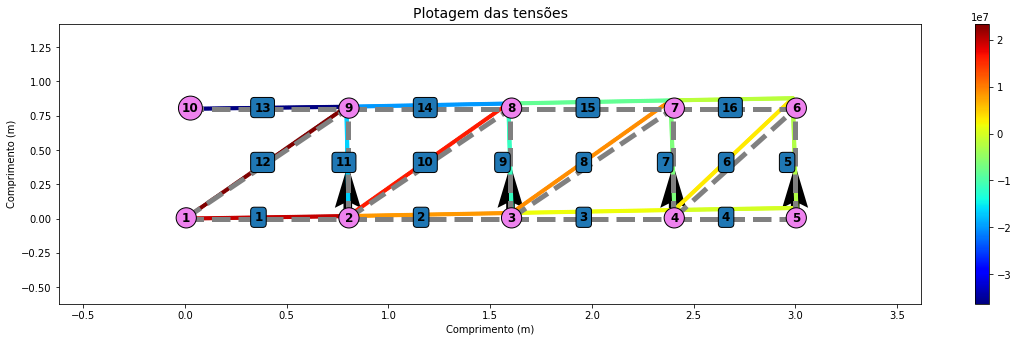

In [ ]:
# Para a treliça apresentada abaixo, determine a tensão no elemento BC. Considere que o material 
# das barras é aço A36 com E=200 GPa e o diâmetro das barras é 10 mm. 
# Você pode adaptar o código desenvolvido na aula 11 ao problema.
# Pré-Processamento
import numpy as np
import copy
# 1) Parâmetros a serem definidos para o a análise via FEM
conec = np.array([[1,2],[2,3],[3,4],[4,5],[5,6],[4,6],[4,7],[3,7],[3,8],[2,8],[2,9],[1,9],[10,9],[9,8],[8,7],[7,6]]) # Matriz conectividade
coord = np.array([[0,0],[0.8,0],[1.6,0],[2.4,0],[3,0],[3,0.8],[2.4,0.8],[1.6,0.8],[0.8,0.8],[0,0.8]]) # Matriz coordenadas nodais
# -----------------------------------------------------------------------------
nel = len(conec) # Número de elementos totais
nno = len(coord) # Número de nós
# -----------------------------------------------------------------------------
E = 200E9*np.ones(nel) # Módulo de elasticidade elementar
D = 0.01*np.ones(nel) # Diâmetro de cada elemento
# -----------------------------------------------------------------------------
# 2a) Defina os graus de liberdade que contenham as condições de contorno de deslocamento
# lembrando que os graus de liberdade no python começam em 0
CCDir_gdl = [0,1,18,19]
# 2b) Defina os graus de liberdade que contenham as condições de contorno de força e seu respectivo valor
# lembrando que os graus de liberdade no python começam em 0
F_gdl = np.array([[3,400],[5,400],[7,300],[9,200]])
# -----------------------------------------------------------------------------
# 3) Defina um fator de amplificação para plotagem
SF = 20 # Fator de escala
# -----------------------------------------------------------------------------
# Processamento
# Superposição da matriz Kg
Kg = np.zeros((2*nno,2*nno)) # Abrindo espaço para matriz de rigidez global (NGdl,NGdl)
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Vetor comprimento dos elementos
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matriz de transformação de coordenadas
    A = np.pi*(D[el]/2)**2 # Área elementar
    k = (E[el]*A/L)*np.array([[1,-1],[-1,1]])
    ke = np.transpose(T).dot(k).dot(T)
    # Superposição da matriz elementar na matriz de rigidez global --------
    # Posições dos GLs nodais no sistema global
    GLel = np.array([[2*no1 - 2],[2*no1 - 1],[2*no2 - 2],[2*no2 - 1]])
    for i in range(0,len(GLel)):
        for j in range(0,len(GLel)):
            Kg[GLel[i],GLel[j]] = Kg[GLel[i],GLel[j]] + ke[i,j]         
Kg1 = copy.deepcopy(Kg)
# Aplicação das condições de contorno
# Condições de contorno de força
F = np.zeros((2*nno))
for igl in range(len(F_gdl)):
  F[F_gdl[igl,0]] = F_gdl[igl,1]
# Condições de contorno de deslocamento 
CCDir = np.zeros((2*nno,2))
for i in range(len(CCDir_gdl)):
  CCDir[CCDir_gdl[i],0] = 1   
for igl in range(2*nno):
  if CCDir[igl-1,0] == 1:
    up = CCDir[igl-1,1]  
    for i in range(2*nno): # zera linha e coluna
      Kg[i-1,igl-1] = 0.0
      Kg[igl-1,i-1] = 0.0   
    Kg[igl-1,igl-1] = 1; # Prescreve 1 no G.L. 
# Solução do sistema linear de equações
d = np.linalg.solve(Kg,F)
# Pós-processamento
e = np.zeros((nel,1))
Tens = np.zeros((nel,1))
for el in range(0,nel):
    # Cálculo do deslocamento elementar
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Vetor comprimento dos elementos
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matriz de transformação de coordenadas
    d_el = np.array([d[2*no1 - 2],d[2*no1-1],d[2*no2 - 2],d[2*no2-1]])
    u = T.dot(d_el)
    # Cálculo da deformação e tensão elementar
    e[el] = (u[1] - u[0])/L
    Tens[el] = E[el]*e[el]
    print('Tensão', el+1, ' =', np.format_float_scientific(float(Tens[el]), precision = 3, exp_digits=1),'Pa')
print('')
# Plotagem dos resultados
import matplotlib.pyplot as plt
SizeSpace = (max(coord[:,0])**2 + max(coord[:,1])**2)**0.5
fig, axs = plt.subplots(1,1,figsize=((max(coord[:,0])/SizeSpace)*SF,(max(coord[:,1])/SizeSpace)*SF))
axs.set(xlim=(-0.2*SizeSpace, max(coord[:,0])+0.2*SizeSpace), ylim=(-0.2*SizeSpace, max(coord[:,1])+0.2*SizeSpace)) 
#plt.fig(figsize=((max(coord[:,0])/SizeSpace)*SF,(max(coord[:,1])/SizeSpace)*SF))
# Plotagem da estrutura inicial
# Plotagem dos nós
nox = coord[:,0]
noy = coord[:,1]
# Número dos nós
for i in range(nno):
    plt.text(nox[i]-max(coord[:,0])*0.005, noy[i]-max(coord[:,1])*0.025, i+1, 
             fontsize=12,fontweight='bold',bbox=dict(boxstyle="circle,pad=0.3", fc="violet"))    
# Número dos elementos
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    plt.text(coord[no1-1,0]+ x/2-max(coord[:,0])*0.02, coord[no1-1,1]+y/2-max(coord[:,1])*0.02, el+1, 
             fontsize=12,fontweight='bold',bbox=dict(boxstyle="round"))    
# Plotagem das forças
for ino in range(0,nno):
  if F[2*ino] != 0:
    xix = coord[ino,0]
    yix = coord[ino,1]
    xfx = F[2*ino]/abs(F[2*ino])
    yfx = 0
    plt.quiver(xix,yix,xfx,yfx,scale = SF*max(coord[:,0]),width=0.01)
  if F[2*ino+1] != 0:
    xiy = coord[ino,0]
    yiy = coord[ino,1]
    xfy = 0
    yfy = F[2*ino+1]/abs(F[2*ino+1])
    plt.quiver(xiy,yiy,xfy,yfy,scale = SF*max(coord[:,1]),width=0.01)  
# Plotagem da estrutura inicial     
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0]
    y1 = coord[no1-1,1]
    x2 = coord[no2-1,0]
    y2 = coord[no2-1,1]
    plt.plot([x1,x2],[y1,y2],color='grey',linestyle='--',linewidth=5)        
disc = 100 # discretização
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
colors = np.zeros((nel*disc))
diamplot = np.zeros((nel*disc))
from numpy.linalg import norm
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0] + (0.05*SizeSpace/norm(d))*d[2*no1 - 2] 
    y1 = coord[no1-1,1] + (0.05*SizeSpace/norm(d))*d[2*no1-1]
    x2 = coord[no2-1,0] + (0.05*SizeSpace/norm(d))*d[2*no2 - 2]
    y2 = coord[no2-1,1] + (0.05*SizeSpace/norm(d))*d[2*no2-1]
    x_aux = np.asfarray(np.linspace(x1,x2,disc), dtype='float')
    y_aux = np.asfarray(np.linspace(y1,y2,disc), dtype='float')
    for j in range(0,disc):
        x[disc*(el+1)-disc+j] = x_aux[j]
        y[disc*(el+1)-disc+j] = y_aux[j]
        colors[disc*(el+1)-disc+j] = Tens[el]
        diamplot[disc*(el+1)-disc+j] = 1e3*D[el]  
plt.scatter(x,y,c=colors,s=diamplot, cmap='jet') 
plt.colorbar()     
plt.title("Plotagem das tensões", fontsize=14)
plt.xlabel('Comprimento (m)')  
plt.ylabel('Comprimento (m)')  